In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from neural_odes import *
from tqdm import tqdm_notebook as tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Simple Explicit ODE Solvers to solve $\frac{dy}{dt} = f(t,y) = 2 \iff y(t) = 2t + y_0$. (Linear case)

In [2]:
dt = 0.01
t0 = 0
y0 = torch.Tensor([1.0]).float()
Tn = 1
t = torch.arange(t0, Tn+dt, dt).float()
N = len(t)

In [3]:
print(f'The number of time steps = {N-1}')

The number of time steps = 100


### 1) 4 stage explicit Runge Kutta

In [4]:
# Define function
# Problem is this is a lambda function and can only learn nd array
C = 2
f = lambda t,y : C

In [5]:
def ode_solver(f, t, y0, solver):
    y = []
    # Inital condiiton
    y.append(y0)
    if solver == 'rk4':
        for n in range(0, N-1):
            k1 = dt * f(t[n], y[n]) #f is lambd function
            k2 = dt * f(t[n] + dt/2, y[n] + k1/2)
            k3 = dt * f(t[n] + dt/2, y[n] + k2/2)
            k4 = dt * f(t[n] + dt, y[n] + k3)
            y.append(y[n] + 1/6 * (k1 + 2*k2 + 2*k3 + k4))
            
    elif solver == 'forward_euler':
        for n in range(0,N-1):
            y.append(y[n] + dt * f(t[n],y[n]))
    else:
        print('ODE solver is not supported!')
    return torch.cat(y, dim = 0)

In [6]:
y_rk4 = ode_solver(f,t,y0, 'rk4')

### 2) Forward Euler

In [7]:
y_fe = ode_solver(f, t, y0, 'forward_euler')

 ### Exact Solution

In [8]:
y_exact = 2*t + y0

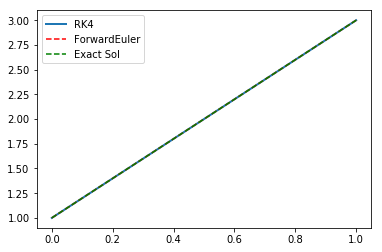

In [9]:
plt.plot(t,y_rk4.numpy(), lw=2)
plt.plot(t,y_fe.numpy(), 'r--')
plt.plot(t,y_exact.numpy(), 'g--')
plt.legend(('RK4', 'ForwardEuler', 'Exact Sol'))

In [10]:
err_rk = torch.max(torch.abs(y_rk4-y_exact))
print(f'RK4 Absolute error = {err_rk}')

RK4 Absolute error = 1.9073486328125e-06


In [11]:
err_fe = torch.max(torch.abs(y_fe-y_exact))
print(f'Forward Euler Absolute error = {err_fe}')

Forward Euler Absolute error = 1.9073486328125e-06


Text(0.5, 1.0, 'Pointwise Errors')

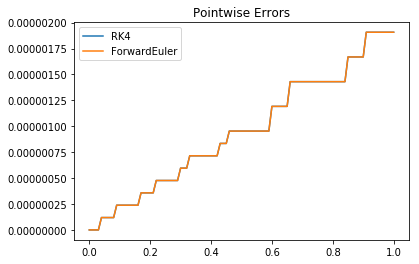

In [12]:
plt.plot(t, torch.abs(y_rk4-y_exact))
plt.plot(t, torch.abs(y_fe-y_exact))
plt.legend(('RK4', 'ForwardEuler'))
plt.title('Pointwise Errors')

## Use simple embedding to learn initial condition $y_0$ or $z_{t_0}$ in time series context.

In [13]:
class InitialCondRNN(nn.Module):      
    def __init__(self, num_ts, num_params):
        super(InitialCondRNN, self).__init__()  
        self.num_ts = num_ts # cardinality = number of time series = 1 for now
        self.num_params = num_params
        self.embedding = nn.Embedding(num_ts, num_params)
    
    def forward(self, f, t):
        y0 = self.embedding(torch.arange(self.num_ts))
        return ode_solver(f, t, y0.squeeze(0), solver)

In [14]:
num_ts = 1
num_params = 1 #learning only initial condition
model = InitialCondRNN(num_ts, num_params)
optimizer = torch.optim.Adam(model.parameters(), 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 1, gamma=0.95)

%%time
num_epochs = 1500
solver = 'rk4'
loss_fun = torch.nn.MSELoss()

tqdm_epochs = tqdm(range(num_epochs))

for e in tqdm_epochs:
    #forward pass
    y = model(f, t)
    Loss = loss_fun(y, y_exact)
    optimizer.zero_grad()
    Loss.backward()
    optimizer.step()
    tqdm_epochs.set_postfix({'loss': torch.sum(Loss).item()})

Text(0, 0.5, 'y')

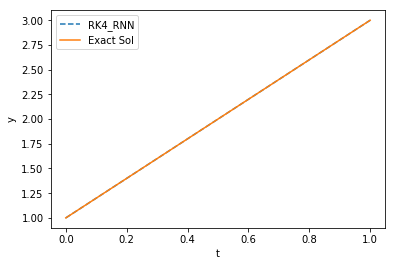

In [18]:
# after 1500 iterations
plt.plot(t.data.numpy(), y.data.numpy(), '--')
plt.plot(t.data.numpy(), y_exact.data.numpy())
plt.legend(('RK4_RNN', 'Exact Sol'))
plt.xlabel('t')
plt.ylabel('y')

## Use simple embedding to learn initial condition $y_0$ or $z_{t_0}$ and in time series context and the function $f(t,y)$

In [19]:
class InitialCond_and_FC(nn.Module):
    def __init__(self, num_ts, num_params):
        super(InitialCond_and_FC, self).__init__()  
        self.num_ts = num_ts # cardinality = number of time series = 1 for now
        self.num_params = num_params
        self.num_vars = 2 #(t,y)
        #self.embedding = nn.Embedding(num_ts, num_params)
        #self.embedding.weight.data.uniform_(1, 1)
        self.y0 = torch.nn.Parameter(torch.cuda.FloatTensor([[1]]))#

        # learn f with 1 layer can only learn linear functions
        self.dynamics = nn.Linear(self.num_vars, 1)
        self.dynamics.weight = torch.nn.Parameter(torch.cuda.FloatTensor([[1,  1]]))
        self.dynamics.bias = torch.nn.Parameter(torch.cuda.FloatTensor([1]))#.data.uniform_(1, 1)

    def forward(self, t):
        #y0 = self.embedding(torch.arange(self.num_ts).to(device))
        # inline Rk4 solver
        y = []
        # Inital condiiton
        y.append(self.y0)
        # Missing forward euler option as in the cosine case
        for n in range(0, N-1):
           # print(t[n].reshape(1,1).shape, y[n].shape,torch.cat([t[n].reshape(1,1), y[n]]).shape)
            f1 = self.dynamics(torch.cat([t[n].reshape(1,1), y[n]], dim = 1))#.reshape(self.num_ts,self.num_vars))
            k1 = dt * f1
            f2 = self.dynamics(torch.cat([(t[n] + dt/2).reshape(1,1), y[n] + k1/2], dim = 1))#.reshape(self.num_ts,self.num_vars))
            k2 = dt * f2
            f3 = self.dynamics(torch.cat([(t[n] + dt/2).reshape(1,1), y[n] + k2/2], dim = 1))#.reshape(self.num_ts,self.num_vars))
            k3 = dt * f3
            f4 = self.dynamics(torch.cat([(t[n] + dt).reshape(1,1), y[n] + k3], dim = 1))#.reshape(self.num_ts,self.num_vars))
            k4 = dt * f4
            y.append(y[n] + 1/6 * (k1 + 2*k2 + 2*k3 + k4))
        return torch.cat(y, dim=0)
    
    
# class InitialCond_and_f_RNN(gluon.HybridBlock):
    
#     def __init__(self, num_ts, num_params, dtype=dtype, **kwargs):
#         super().__init__(**kwargs)
#         self.num_ts = num_ts # cardinality = number of time series = 1 for now
#         self.num_params = num_params
#         self.dtype = dtype
#         self.num_vars = 2 #(t,y)
#         with self.name_scope():
#             self.embedding = gluon.nn.Embedding( # learn initial conditions
#                 input_dim=self.num_ts,
#                 output_dim=self.num_params,
#                 dtype=self.dtype
#             )
#             # learn f with 1 layer can only learn linear functions
#             self.dynamics = gluon.nn.Dense(units = self.num_ts,dtype=self.dtype)
    
#     def forward(self, t, ts_idx):
#         y0 = self.embedding(ts_idx)
#         # inline Rk4 solver
#         y = []
#         # Inital condiiton
#         y.append(y0)
#         # Missing forward euler option as in the cosine case
#         for n in range(0, N-1):
#             f1 = self.dynamics(nd.concat(t[n], *y[n], dim=0).reshape(self.num_ts,self.num_vars))
#             k1 = dt * f1
#             f2 = self.dynamics(nd.concat(t[n] + dt/2, *y[n] + k1/2, dim=0).reshape(self.num_ts,self.num_vars))
#             k2 = dt * f2
#             f3 = self.dynamics(nd.concat(t[n] + dt/2, *y[n] + k2/2, dim=0).reshape(self.num_ts,self.num_vars))
#             k3 = dt * f3
#             f4 = self.dynamics(nd.concat(t[n] + dt, *y[n] + k3, dim=0).reshape(self.num_ts,self.num_vars))
#             k4 = dt * f4
#             y.append(y[n] + 1/6 * (k1 + 2*k2 + 2*k3 + k4))
#         return nd.concat(*y, dim=0)

In [26]:
num_ts = 1
num_params = 1 #learning only initial condition
model = InitialCond_and_FC(num_ts, num_params).to(device)
optimizer = torch.optim.Adagrad(model.parameters(), 0.01)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 1, gamma=0.99)

%%time
num_epochs = 500
solver = 'rk4'
loss_fun = torch.nn.MSELoss()

tqdm_epochs = tqdm(range(num_epochs))

for e in tqdm_epochs:
    #forward pass
    y = model(t.to(device))
    loss = loss_fun(y.to(device), y_exact.to(device))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    tqdm_epochs.set_postfix({'loss': torch.sum(loss).item()})

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([101])) that is different to the input size (torch.Size([101, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



CPU times: user 1min 32s, sys: 107 ms, total: 1min 32s
Wall time: 1min 32s


In [23]:
model.dynamics.bias

Parameter containing:
tensor([0.4238], device='cuda:0', requires_grad=True)

In [24]:
model.dynamics.weight

Parameter containing:
tensor([[ 0.6344, -0.1751]], device='cuda:0', requires_grad=True)

Text(0, 0.5, 'y')

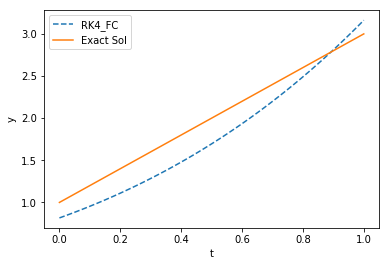

In [28]:
y = model(t.to(device))
# after 4500 iterations reasonable at 3000
plt.plot(t.cpu().data.numpy(),y.cpu().data.numpy(), '--')
plt.plot(t.cpu().data.numpy(),y_exact.cpu().data.numpy())
plt.legend(('RK4_FC', 'Exact Sol'))
plt.xlabel('t')
plt.ylabel('y')

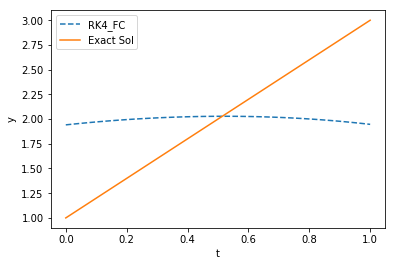

In [61]:
# after 4500 iterations reasonable at 3000
plt.plot(t.cpu().data.numpy(),y.cpu().data.numpy(), '--')
plt.plot(t.cpu().data.numpy(),y_exact.cpu().data.numpy())
plt.legend(('RK4_FC', 'Exact Sol'))
plt.xlabel('t')
plt.ylabel('y')
#plt.savefig("RK4_FC_failure.png", dpi = 300 , bbox_inches = "tight")

In [107]:
for n in range(N):
    print(model.dynamics(torch.cat([t[n].reshape(1,1).to(device), y[n].reshape(1,1)]).reshape(1,2)))
sum_f / N

tensor([[-0.0792]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0771]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0750]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0728]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0707]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0685]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0663]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0641]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0619]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0597]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0574]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0551]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0529]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0506]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0482]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0459]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([

tensor([[0.4589]], device='cuda:0', grad_fn=<DivBackward0>)

In [ ]:
# model.embedding(torch.arange(num_ts).to(device)) #initial condition
# model.dynamics(torch.cat([t[0].reshape(1,1).to(device), y[0].reshape(1,1)]).reshape(1,2))
# sum_f = 0
# for n in range(N):
#     sum_f += model.dynamics(torch.cat([t[n].reshape(1,1).to(device), y[n].reshape(1,1)]).reshape(1,2))
# sum_f / N # should be close to C = 2
# torch.abs(C-sum_f / N)
# model.dynamics(torch.cat([t[100].reshape(1,1).to(device), y[100].reshape(1,1)]).reshape(1,2))